# Pneumonia Detection In Pediatric Chest Xrays
### Author: Jaclyn Dwyer

![example](images/Altus-fb-logo-1.jpeg)

In [1]:
import os, shutil
from pathlib import Path
import time
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
from keras import models, layers, regularizers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img
import tensorflow as tf
np.random.seed(123)

## Data Preparation

The path to the data directory is defined in order to work with the imaging data. Within the data directory there are three folder, train, test, and validation, which each contain a folder of normal xrays and a folder of pneumonia xrays. For this project the test and validation data are switched due to the small size of the original validation set.

In [2]:
# path to the data directory
data_dir = Path('data/chest_xray/chest_xray')

# Path to train, validation, test directory
train_folder = data_dir / 'train'
test_folder = data_dir / 'val'
val_folder = data_dir / 'test'

In [3]:
# path to the normal and pneumonia sections
train_n_folder = train_folder / 'NORMAL'
train_p_folder = train_folder/ 'PNEUMONIA'

val_n_folder = val_folder / 'NORMAL'
val_p_folder = val_folder / 'PNEUMONIA'

test_n_folder = test_folder / 'NORMAL'
test_p_folder = test_folder / 'PNEUMONIA'

### Store Images
A list is created to store all of the image names for the normal and pneumonia xrays in the train, validation, and test sets.

In [4]:
#create list to store images
train_n = [file for file in os.listdir(train_n_folder) if file.endswith('.jpeg')]
train_p = [file for file in os.listdir(train_p_folder) if file.endswith('.jpeg')]

val_n = [file for file in os.listdir(val_n_folder) if file.endswith('.jpeg')]
val_p = [file for file in os.listdir(val_p_folder) if file.endswith('.jpeg')]

test_n = [file for file in os.listdir(test_n_folder) if file.endswith('.jpeg')]
test_p = [file for file in os.listdir(test_p_folder) if file.endswith('.jpeg')]

### Image Processing
The images in the sets are processed using Keras' image processing tools. 

In [5]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(64, 64), batch_size= 5216)

Found 5216 images belonging to 2 classes.


In [6]:
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(64, 64), batch_size = 624) 

Found 624 images belonging to 2 classes.


In [7]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), batch_size = 16)

Found 16 images belonging to 2 classes.


**Create Data Sets**

In [8]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [9]:
train_images.shape

(5216, 64, 64, 3)

**Labels**

The fomat of labels are changed. 

In [10]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

**Reshape**

In [11]:
train_img = train_images.reshape(train_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)

In [12]:
print(train_img.shape)
print(val_img.shape)
print(test_img.shape)

(5216, 12288)
(624, 12288)
(16, 12288)


In [13]:
train_y = np.reshape(train_labels[:,0], (5216,1))
val_y = np.reshape(val_labels[:,0], (624,1))
test_y = np.reshape(test_labels[:,0], (16,1))

## Data Visualization

### Xrays Pictures
Xrays are visualized to see what the normal xrays look like compared to the pneumonia xrays. 

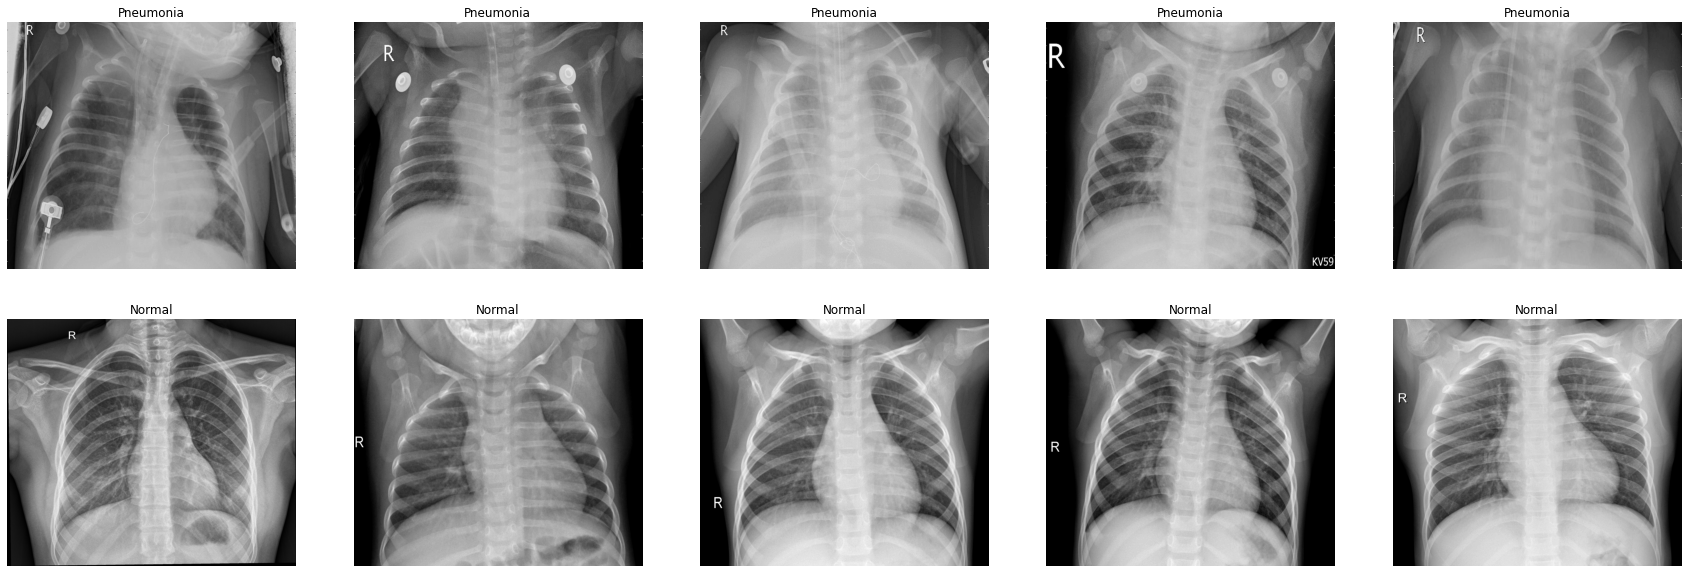

In [14]:
#images to visualize 
train_n_v = train_n_folder.glob('*.jpeg')
train_p_v = train_p_folder.glob('*.jpeg')

# set empty list
train_data = []

# normal data, label 0
for img in train_n_v:
    train_data.append((img,0))

# pneumonia data,label 1
for img in train_p_v:
    train_data.append((img, 1))

# create dataframe 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# obtain five pics from both
pneumonia_pics = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_pics = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# make single list 
pics = pneumonia_pics + normal_pics

# plot data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(pics[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

### Class Imbalance

Plotting the counts for normal xrays and pneumonia xrays shows a class imbalance between the two with more pneumonia xrays. A class weight is created to account for this when creating models. The class weight created equally penalizes a miss in the normal xrays with a miss in the pnuemonia xrays.

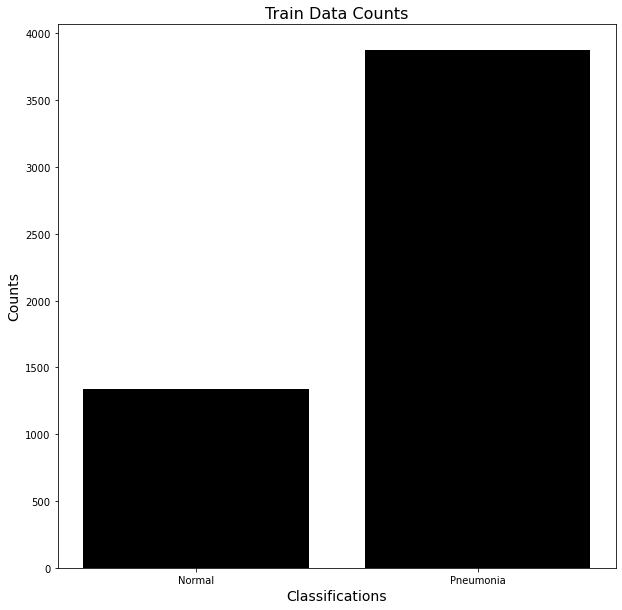

In [15]:
fig,ax = plt.subplots(figsize = (10,10))
x = ['Normal', 'Pneumonia']
y = [len(train_n), len(train_p)]
ax.bar(x,y, color = 'black')
ax.set_title('Train Data Counts', fontsize = 16)
ax.set_xlabel('Classifications', fontsize = 14)
ax.set_ylabel('Counts', fontsize = 14);

In [16]:
#find number normal and pneumonia xrays in train 
print(len(train_n))
print(len(train_p))

1341
3875


In [37]:
#create class_weight
class_weight = {0: (3875/1341), 1: 1}
class_weight

{0: 1, 1: 2.889634601043997}

## Models
Models are created to try and find a model with the best recall score.

### Baseline Model

In [38]:
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(20, activation='relu', input_shape=(12288,))) 
baseline_model.add(layers.Dense(10, activation='relu'))
baseline_model.add(layers.Dense(5, activation='relu'))
baseline_model.add(layers.Dense(1, activation='sigmoid'))

In [39]:
baseline_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall()])

In [40]:
baseline_history = baseline_model.fit(train_img,
                    train_y,
                    epochs=50,
                    class_weight = class_weight,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
163/163 [==============================] - 1s 4ms/step - loss: 1.0312 - accuracy: 0.7086 - recall_3: 0.0902 - val_loss: 0.6910 - val_accuracy: 0.6250 - val_recall_3: 0.0000e+00
Epoch 2/50
163/163 [==============================] - 1s 4ms/step - loss: 1.0300 - accuracy: 0.7429 - recall_3: 0.0000e+00 - val_loss: 0.6924 - val_accuracy: 0.6250 - val_recall_3: 0.0000e+00
Epoch 3/50
163/163 [==============================] - 1s 3ms/step - loss: 1.0300 - accuracy: 0.4224 - recall_3: 0.6413 - val_loss: 0.6923 - val_accuracy: 0.6250 - val_recall_3: 0.0000e+00
Epoch 4/50
163/163 [==============================] - 1s 3ms/step - loss: 1.0300 - accuracy: 0.6302 - recall_3: 0.1984 - val_loss: 0.6926 - val_accuracy: 0.6250 - val_recall_3: 0.0000e+00
Epoch 5/50
163/163 [==============================] - 1s 4ms/step - loss: 1.0300 - accuracy: 0.6007 - recall_3: 0.2483 - val_loss: 0.6931 - val_accuracy: 0.6250 - val_recall_3: 0.0000e+00
Epoch 6/50
163/163 [==============================] - 1s

163/163 [==============================] - 1s 4ms/step - loss: 1.0300 - accuracy: 0.3744 - recall_3: 0.7271 - val_loss: 0.6932 - val_accuracy: 0.3750 - val_recall_3: 1.0000
Epoch 45/50
163/163 [==============================] - 1s 4ms/step - loss: 1.0300 - accuracy: 0.5953 - recall_3: 0.2617 - val_loss: 0.6936 - val_accuracy: 0.3750 - val_recall_3: 1.0000
Epoch 46/50
163/163 [==============================] - 1s 6ms/step - loss: 1.0300 - accuracy: 0.3223 - recall_3: 0.8643 - val_loss: 0.6932 - val_accuracy: 0.3750 - val_recall_3: 1.0000
Epoch 47/50
163/163 [==============================] - 1s 5ms/step - loss: 1.0300 - accuracy: 0.5803 - recall_3: 0.2923 - val_loss: 0.6934 - val_accuracy: 0.3750 - val_recall_3: 1.0000
Epoch 48/50
163/163 [==============================] - 1s 5ms/step - loss: 1.0300 - accuracy: 0.3691 - recall_3: 0.7524 - val_loss: 0.6930 - val_accuracy: 0.6250 - val_recall_3: 0.0000e+00
Epoch 49/50
163/163 [==============================] - 1s 5ms/step - loss: 1.0300 -

In [20]:
baseline_train = baseline_model.evaluate(train_img, train_y)
baseline_val = baseline_model.evaluate(val_img, val_y)

20/20 [==============================] - 0s 2ms/step - loss: 0.7348 - accuracy: 0.7885 - recall: 0.4615


**Scores Data Frame**

In [21]:
#create df of scores
scores = pd.DataFrame([['Baseline Model', 
                        baseline_train[0], baseline_val[0],
                        baseline_train[1], baseline_val[1],
                        baseline_train[2], baseline_val[2]]],
               columns =  ['Model', 
                          'Train Loss', 'Val Loss', 
                          'Train Accuracy', 'Val Accuracy',
                          'Train Recall', 'Val Recall'])
scores

,Model,Train Loss,Val Loss,Train Accuracy,Val Accuracy,Train Recall,Val Recall
0,Baseline Model,0.092226,0.734836,0.963382,0.788462,0.96868,0.461538


### Early Stopping & L1 Model

In [22]:
l1_early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_models/l1_best_model_64.h5', monitor='val_loss', save_best_only=True)]

In [23]:
l1_model = models.Sequential()
l1_model.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l1(0.0005), input_shape=(12288,))) 
l1_model.add(layers.Dense(10, kernel_regularizer=regularizers.l1(0.0005), activation='relu'))
l1_model.add(layers.Dense(5, kernel_regularizer=regularizers.l1(0.0005), activation='relu'))
l1_model.add(layers.Dense(1, activation='sigmoid'))

In [24]:
l1_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall()])

In [25]:
l1_model_history = l1_model.fit(train_img,
                    train_y,
                    epochs=50,
                    class_weight = class_weight,
                    callbacks=l1_early_stopping,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
163/163 [==============================] - 1s 6ms/step - loss: 1.6276 - accuracy: 0.7345 - recall_1: 0.0186 - val_loss: 2.0305 - val_accuracy: 0.6250 - val_recall_1: 0.0000e+00
Epoch 2/50
163/163 [==============================] - 1s 4ms/step - loss: 1.4272 - accuracy: 0.8021 - recall_1: 0.2453 - val_loss: 1.7638 - val_accuracy: 0.6875 - val_recall_1: 0.1709
Epoch 3/50
163/163 [==============================] - 1s 4ms/step - loss: 1.2954 - accuracy: 0.8737 - recall_1: 0.5384 - val_loss: 1.9036 - val_accuracy: 0.6715 - val_recall_1: 0.1282
Epoch 4/50
163/163 [==============================] - 1s 4ms/step - loss: 1.2003 - accuracy: 0.8880 - recall_1: 0.6130 - val_loss: 1.4421 - val_accuracy: 0.7997 - val_recall_1: 0.5342
Epoch 5/50
163/163 [==============================] - 1s 4ms/step - loss: 1.1134 - accuracy: 0.8955 - recall_1: 0.6503 - val_loss: 1.4705 - val_accuracy: 0.7644 - val_recall_1: 0.4017
Epoch 6/50
163/163 [==============================] - 1s 4ms/step - loss: 1.

In [27]:
l1_best_model = load_model('best_models/l1_best_model_64.h5')

In [28]:
l1_train = l1_best_model.evaluate(train_img, train_y)
l1_val = l1_best_model.evaluate(val_img, val_y)

20/20 [==============================] - 0s 3ms/step - loss: 0.7636 - accuracy: 0.7821 - recall_1: 0.5128


In [58]:
#add scores to df
l1_scores = pd.DataFrame([['l1 Model', 
                       l1_train[0], l1_val[0],
                       l1_train[1], l1_val[1], 
                       l1_train[2], l1_val[2]]],
            
               columns =  ['Model', 
                          'Train Loss', 'Val Loss', 
                          'Train Accuracy', 'Val Accuracy',
                          'Train Recall', 'Val Recall'])
scores = scores.append(l1_scores, ignore_index = True)
scores

,Model,Train Loss,Val Loss,Train Accuracy,Val Accuracy,Train Recall,Val Recall
0,Baseline Model,0.073214,0.904359,0.974885,0.761218,0.950037,0.384615
1,l1 Model,0.408246,0.763620,0.942676,0.782051,0.968680,0.512821


### L2 Model

In [49]:
l2_early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_models/l2_best_model_64.h5', monitor='val_loss', save_best_only=True)]

In [50]:
l2_model = models.Sequential()
l2_model.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.0005), input_shape=(12288,))) 
l2_model.add(layers.Dense(10, kernel_regularizer=regularizers.l2(0.0005), activation='relu'))
l2_model.add(layers.Dense(5, kernel_regularizer=regularizers.l2(0.0005), activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [51]:
l2_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall()])

In [52]:
l2_history = l2_model.fit(train_img,
                    train_y,
                    epochs=50,
                    class_weight = class_weight,
                    callbacks=l2_early_stopping,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
163/163 [==============================] - 1s 5ms/step - loss: 0.7521 - accuracy: 0.7579 - recall_5: 0.0895 - val_loss: 1.5263 - val_accuracy: 0.6250 - val_recall_5: 0.0000e+00
Epoch 2/50
163/163 [==============================] - 1s 4ms/step - loss: 0.5064 - accuracy: 0.8438 - recall_5: 0.4407 - val_loss: 0.4633 - val_accuracy: 0.7901 - val_recall_5: 0.5000
Epoch 3/50
163/163 [==============================] - 1s 4ms/step - loss: 0.4314 - accuracy: 0.8863 - recall_5: 0.6189 - val_loss: 0.5639 - val_accuracy: 0.7628 - val_recall_5: 0.3974
Epoch 4/50
163/163 [==============================] - 1s 4ms/step - loss: 0.3506 - accuracy: 0.9087 - recall_5: 0.6972 - val_loss: 1.0669 - val_accuracy: 0.6827 - val_recall_5: 0.1581
Epoch 5/50
163/163 [==============================] - 1s 4ms/step - loss: 0.3454 - accuracy: 0.9128 - recall_5: 0.7159 - val_loss: 0.9090 - val_accuracy: 0.7051 - val_recall_5: 0.2265
Epoch 6/50
163/163 [==============================] - 1s 4ms/step - loss: 0.

In [26]:
l2_best_model = load_model('best_models/l2_best_model_64.h5')

In [27]:
l2_train = l2_best_model.evaluate(train_img, train_y)
l2_val = l2_best_model.evaluate(val_img, val_y)

20/20 [==============================] - 0s 3ms/step - loss: 0.4633 - accuracy: 0.7901 - recall_5: 0.5000


In [28]:
#add scores to df
l2_scores = pd.DataFrame([['l2 Model', 
                       l2_train[0], l2_val[0],
                       l2_train[1], l2_val[1],
                       l2_train[2], l2_val[2]]],
            
               columns =  ['Model', 
                          'Train Loss', 'Val Loss', 
                          'Train Accuracy', 'Val Accuracy',
                          'Train Recall', 'Val Recall'])
scores = scores.append(l2_scores, ignore_index = True)
scores

,Model,Train Loss,Val Loss,Train Accuracy,Val Accuracy,Train Recall,Val Recall
0,Baseline Model,0.092226,0.734836,0.963382,0.788462,0.968680,0.461538
1,l2 Model,0.226144,0.463268,0.929831,0.790064,0.850858,0.500000


### Dropout Model

In [29]:
drop_l1_early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_models/drop_l1_best_model_64.h5', monitor='val_loss', save_best_only=True)]

In [30]:
drop_l1_model = models.Sequential()
drop_l1_model.add(layers.Dropout(0.1, input_shape=(12288,)))
drop_l1_model.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l1(0.0005))) 
drop_l1_model.add(layers.Dropout(0.1))
drop_l1_model.add(layers.Dense(10, kernel_regularizer=regularizers.l1(0.0005), activation='relu'))
drop_l1_model.add(layers.Dropout(0.1))
drop_l1_model.add(layers.Dense(5, kernel_regularizer=regularizers.l1(0.0005), activation='relu'))
drop_l1_model.add(layers.Dropout(0.1))
drop_l1_model.add(layers.Dense(1, activation='sigmoid'))

In [31]:
drop_l1_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall()])

In [32]:
drop_l1_history = drop_l1_model.fit(train_img,
                    train_y,
                    epochs=50,
                    class_weight = class_weight,
                    callbacks=drop_l1_early_stopping,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
163/163 [==============================] - 1s 7ms/step - loss: 1.6040 - accuracy: 0.7425 - recall_2: 0.0052 - val_loss: 1.8514 - val_accuracy: 0.6250 - val_recall_2: 0.0000e+00
Epoch 2/50
163/163 [==============================] - 1s 6ms/step - loss: 1.4500 - accuracy: 0.7427 - recall_2: 0.0022 - val_loss: 2.0800 - val_accuracy: 0.6250 - val_recall_2: 0.0000e+00
Epoch 3/50
163/163 [==============================] - 1s 6ms/step - loss: 1.3369 - accuracy: 0.7427 - recall_2: 0.0000e+00 - val_loss: 2.5205 - val_accuracy: 0.6250 - val_recall_2: 0.0000e+00
Epoch 4/50
163/163 [==============================] - 1s 6ms/step - loss: 1.2303 - accuracy: 0.7429 - recall_2: 0.0000e+00 - val_loss: 1.9789 - val_accuracy: 0.6250 - val_recall_2: 0.0000e+00
Epoch 5/50
163/163 [==============================] - 1s 6ms/step - loss: 1.1407 - accuracy: 0.7429 - recall_2: 0.0000e+00 - val_loss: 1.7241 - val_accuracy: 0.6250 - val_recall_2: 0.0000e+00
Epoch 6/50
163/163 [============================

In [33]:
drop_l1_best_model = load_model('best_models/drop_l1_best_model_64.h5')

In [34]:
drop_l1_train = drop_l1_best_model.evaluate(train_img, train_y)
drop_l1_val = drop_l1_best_model.evaluate(val_img, val_y)

20/20 [==============================] - 0s 2ms/step - loss: 0.9357 - accuracy: 0.7212 - recall_2: 0.2778


In [35]:
#add scores to df
drop_l1_scores = pd.DataFrame([['Dropout & l1 Model', 
                       drop_l1_train[0], drop_l1_val[0],
                       drop_l1_train[1], drop_l1_val[1],
                       drop_l1_train[2], drop_l1_val[2]]],
            
               columns =  ['Model', 
                          'Train Loss', 'Val Loss', 
                          'Train Accuracy', 'Val Accuracy',
                          'Train Recall', 'Val Recall'])
scores = scores.append(drop_l1_scores, ignore_index = True)
scores

,Model,Train Loss,Val Loss,Train Accuracy,Val Accuracy,Train Recall,Val Recall
0,Baseline Model,0.092226,0.734836,0.963382,0.788462,0.968680,0.461538
1,l2 Model,0.226144,0.463268,0.929831,0.790064,0.850858,0.500000
2,Dropout & l1 Model,0.502679,0.935734,0.946894,0.721154,0.832215,0.277778


### Drop Model l2

In [36]:
drop_l2_early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_models/drop_l2_best_model_64.h5', monitor='val_loss', save_best_only=True)]

In [88]:
drop_l2_model = models.Sequential()
drop_l2_model.add(layers.Dropout(0.1, input_shape=(12288,)))
drop_l2_model.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.0005))) 
drop_l2_model.add(layers.Dropout(0.1))
drop_l2_model.add(layers.Dense(10, kernel_regularizer=regularizers.l2(0.0005), activation='relu'))
drop_l2_model.add(layers.Dropout(0.1))
drop_l2_model.add(layers.Dense(5, kernel_regularizer=regularizers.l2(0.0005), activation='relu'))
drop_l2_model.add(layers.Dropout(0.1))
drop_l2_model.add(layers.Dense(1, activation='sigmoid'))

In [89]:
drop_l2_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall()])

In [90]:
drop_l2_history = drop_l1_model.fit(train_img,
                    train_y,
                    epochs=50,
                    class_weight = class_weight,
                    callbacks=drop_l2_early_stopping,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
163/163 [==============================] - 1s 7ms/step - loss: 0.5047 - accuracy: 0.9233 - recall_8: 0.7964 - val_loss: 1.6060 - val_accuracy: 0.6843 - val_recall_8: 0.1624
Epoch 2/50
163/163 [==============================] - 1s 6ms/step - loss: 0.5197 - accuracy: 0.9176 - recall_8: 0.7837 - val_loss: 1.1099 - val_accuracy: 0.7372 - val_recall_8: 0.3205
Epoch 3/50
163/163 [==============================] - 1s 6ms/step - loss: 0.5324 - accuracy: 0.9166 - recall_8: 0.7808 - val_loss: 0.7416 - val_accuracy: 0.8013 - val_recall_8: 0.5641
Epoch 4/50
163/163 [==============================] - 1s 6ms/step - loss: 0.5176 - accuracy: 0.9181 - recall_8: 0.7793 - val_loss: 1.1133 - val_accuracy: 0.7340 - val_recall_8: 0.3120
Epoch 5/50
163/163 [==============================] - 1s 6ms/step - loss: 0.5111 - accuracy: 0.9210 - recall_8: 0.7905 - val_loss: 1.4680 - val_accuracy: 0.7019 - val_recall_8: 0.2179
Epoch 6/50
163/163 [==============================] - 1s 6ms/step - loss: 0.4950

In [91]:
drop_l2_best_model = load_model('best_models/drop_l2_best_model_64.h5')

In [92]:
drop_l2_train = drop_l2_best_model.evaluate(train_img, train_y)
drop_l2_val = drop_l2_best_model.evaluate(val_img, val_y)

20/20 [==============================] - 0s 3ms/step - loss: 0.7416 - accuracy: 0.8013 - recall_8: 0.5641


In [93]:
#add scores to df
drop_l2_scores = pd.DataFrame([['Dropout & l2 Model', 
                       drop_l2_train[0], drop_l2_val[0],
                       drop_l2_train[1], drop_l2_val[1]]],
            
               columns =  ['Model', 
                          'Train Loss', 'Val Loss', 
                          'Train Recall', 'Val Recall'])
scores = scores.append(drop_l2_scores, ignore_index = True)
scores

,Model,Train Loss,Val Loss,Train Accuracy,Val Accuracy,Train Recall,Val Recall
0,Baseline Model,0.073214,0.904359,0.974885,0.761218,0.950037,0.384615
1,l1 Model,0.408246,0.763620,0.942676,0.782051,0.968680,0.512821
2,l2 Model,0.226144,0.463268,0.929831,0.790064,0.850858,0.500000
3,Dropout & l1 Model,0.456783,0.934711,0.954946,0.775641,0.924683,0.440171
4,Dropout & l1 Model,0.547529,0.782399,0.928489,0.815705,0.973900,0.632479
5,Dropout & l2 Model,0.356557,0.741562,NaN,NaN,0.944977,0.801282


## CNN

In [94]:
cnn_early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_models/cnn_best_model_64.h5', monitor='val_loss', save_best_only=True)]

In [95]:
cnn_model = models.Sequential()
cnn_model.add(layers.Dropout(0.1, input_shape=(64, 64, 3)))
cnn_model.add(layers.Conv2D(16, (3, 3), activation='relu', padding = 'same'))
cnn_model.add(layers.Dropout(0.1))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'))
cnn_model.add(layers.Dropout(0.1))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
cnn_model.add(layers.Dropout(0.1))
cnn_model.add(layers.MaxPooling2D((2, 2)))

In [96]:
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(1, activation='sigmoid'))

In [97]:
cnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_20 (Dropout)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
dropout_21 (Dropout)         (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
dropout_22 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)      

In [98]:
cnn_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall()])

In [99]:
cnn_history = cnn_model.fit(train_images,
                    train_y,
                    epochs=10,
                    class_weight = class_weight,
                    callbacks = cnn_early_stopping,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Epoch 1/10
163/163 [==============================] - 17s 107ms/step - loss: 0.7992 - accuracy: 0.7398 - recall_11: 0.0060 - val_loss: 0.7142 - val_accuracy: 0.6250 - val_recall_11: 0.0000e+00
Epoch 2/10
163/163 [==============================] - 17s 105ms/step - loss: 0.6828 - accuracy: 0.7686 - recall_11: 0.1096 - val_loss: 0.5788 - val_accuracy: 0.6282 - val_recall_11: 0.0085
Epoch 3/10
163/163 [==============================] - 18s 110ms/step - loss: 0.5049 - accuracy: 0.8328 - recall_11: 0.3990 - val_loss: 1.3394 - val_accuracy: 0.6250 - val_recall_11: 0.0000e+00
Epoch 4/10
163/163 [==============================] - 18s 113ms/step - loss: 0.3800 - accuracy: 0.8838 - recall_11: 0.5928 - val_loss: 0.6276 - val_accuracy: 0.6795 - val_recall_11: 0.1538
Epoch 5/10
163/163 [==============================] - 19s 116ms/step - loss: 0.3232 - accuracy: 0.9064 - recall_11: 0.6853 - val_loss: 0.5778 - val_accuracy: 0.7179 - val_recall_11: 0.2650
Epoch 6/10
163/163 [===========================

In [100]:
cnn_best_model = load_model('best_models/cnn_best_model_64.h5')

In [101]:
cnn_train = cnn_best_model.evaluate(train_images, train_y)
cnn_val = cnn_best_model.evaluate(val_images, val_y)

20/20 [==============================] - 1s 26ms/step - loss: 0.5247 - accuracy: 0.7516 - recall_11: 0.3718
